# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-01-17 06:32:43,253 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-01-17 06:32:43,267 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Filters

In [5]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [6]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [7]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQTAxNUZTS0FfUU9TXzE5MTEyOF8xOTExMjhfMTMzNDI5X2NvbnRhY3QnLCBsYXlvdXQ9TGHigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [10]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [11]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [12]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [13]:
group1.run()
group2.run()

Parsing TEST1_POS_191010_191010_192902_contact.html - 178878 lines are Ok
Parsing TEST2TTTT_POS_191010_191010_231835_contact.html - 204101 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [14]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

TEST_TEST1_POS_191010_191010_192902_contact


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
13344.0,NaN,NaN,NaN,693.366,NaN,11.550,NaN,NaN
13408.0,NaN,NaN,NaN,153.016,NaN,17.790,NaN,NaN
13314.0,19.678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4136.0,NaN,3.388,3.762,NaN,NaN,NaN,NaN,NaN
4137.0,NaN,2.727,1.122,NaN,NaN,NaN,NaN,NaN
6314.0,NaN,129.184,64.350,NaN,348.342,NaN,35.388,NaN
4715.0,0.541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13424.0,NaN,NaN,NaN,336509.506,NaN,13.965,NaN,NaN


In [15]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

TEST_TEST2TTTT_POS_191010_191010_231835_contact


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
13605.0,NaN,NaN,NaN,399.454,NaN,15.011,NaN,NaN
13478.0,NaN,NaN,NaN,78.043,NaN,55.525,NaN,NaN
4134.0,NaN,1.681,0.068,NaN,NaN,NaN,NaN,NaN
4135.0,NaN,3.835,1.117,NaN,NaN,NaN,NaN,NaN
13559.0,NaN,NaN,NaN,704.332,NaN,10.575,NaN,NaN
6317.0,NaN,129.567,64.331,NaN,341.462,NaN,32.807,NaN
4719.0,0.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13583.0,NaN,NaN,NaN,328273.767,NaN,17.336,NaN,NaN
4305.0,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [16]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
    sum_df1.index = [group1.title]
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)
except:
    print("No launching time")

list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
    sum_df2.index = [group2.title]
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

    pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])
except:
    print("No launching time")

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [17]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
TEST_TEST1_POS_191010_191010_192902_contact     time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
TEST_TEST2TTTT_POS_191010_191010_231835_contact time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                            time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                           Choreographer #0  \
TEST_TEST1_POS_191010_191010_192902_contact     time                                129.184   
                                                RUNNING                             104.797   
                                                RUNNABLE                              0.690   
                                                SLEEPING                             21.395   
                                                UNINTERUPTIBLE_SLEEP                  0.124   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.178   
TEST_TEST2TTTT_POS_191010_191010_231835_contact time                                129.567   
                                                RUNNING                             103.258   
                                                RUNNABLE                              0.779   
                                                SLEEPING                             22.850   
                                                UNINTERUPTIBLE_SLEEP                  0.102   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.578   
DIFF                                            time                                 -0.383   
                                                RUNNING                               1.539   
                                                RUNNABLE                             -0.089   
                                                SLEEPING                             -1.455   
                                                UNINTERUPTIBLE_SLEEP                  0.022   
                                                UNINTERUPTIBLE_SLEEP(I/O)            -0.400   

                                                                           Choreographer #1  \
TEST_TEST1_POS_191010_191010_192902_contact     time                                 64.350   
                                                RUNNING                              20.804   
                                                RUNNABLE                              0.123   
                                                SLEEPING                             42.932   
                                                UNINTERUPTIBLE_SLEEP                  0.000   
       

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
TEST_TEST1_POS_191010_191010_192902_contact,time,0,129.184,64.350,0,348.342,0,35.388,0
TEST_TEST2TTTT_POS_191010_191010_231835_contact,time,0,129.567,64.331,0,341.462,0,32.807,0
DIFF,time,0,-0.383,0.019,0,6.880,0,2.581,0


### Processing time of setSurface

In [18]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [19]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,avg
TEST_TEST1_POS_191010_191010_192902_contact,19.678,19.678
TEST_TEST2TTTT_POS_191010_191010_231835_contact,17.710,17.710


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [20]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

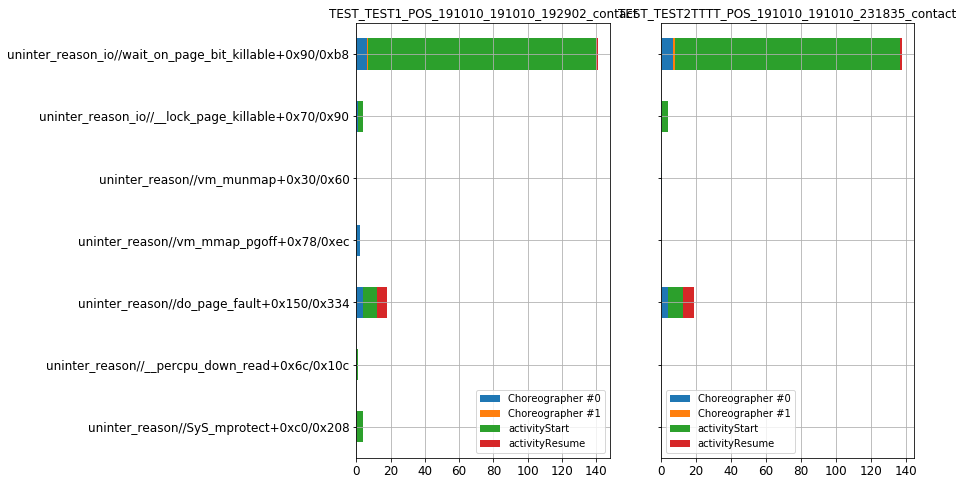

In [21]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

The number of count in each reason of uninterruptible sleep.

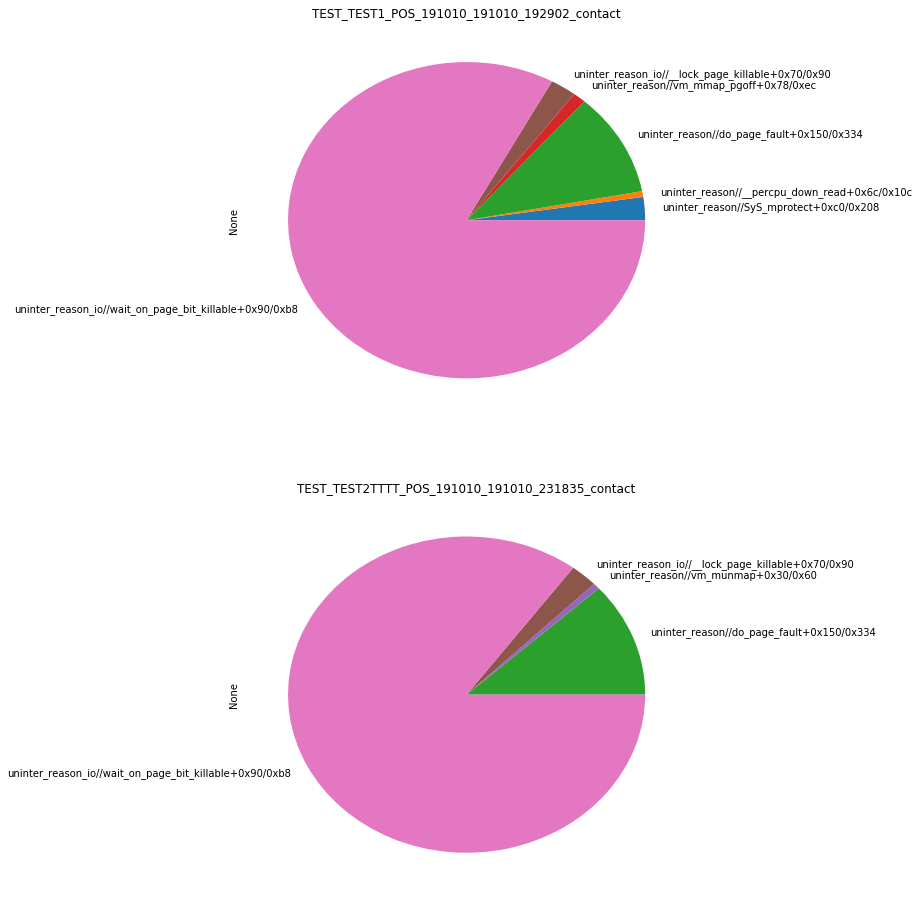

In [22]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

Choreographer #0  \
TEST_TEST1_POS_191010_191010_192902_contact     core0                 2   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 1   
                                                core5                 1   
                                                core6                14   
                                                core7                20   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0                 0   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 1   
                                                core5                 0   
                                                core6                 7   
                                                core7                27   

                                                       Choreographer #1  \
TEST_TEST1_POS_191010_191010_192902_contact     core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 5   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 5   

                                                       activityStart  \
TEST_TEST1_POS_191010_191010_192902_contact     core0             29   
                                                core1             21   
                                                core2             17   
                                                core3             15   
                                                core4             23   
                                                core5             31   
                                                core6             62   
                                                core7             81   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0             19   
                                                core1              9   
                                                core2             14   
                                                core3              8   
                                                core4             25   
                                                core5             21   
                                                core6             47   
                                                core7             94   

                                                       activityResume  
TEST_TEST1_POS_191010_191010_192902_contact     core0               0  
                                                core1               0  
                                                core2         

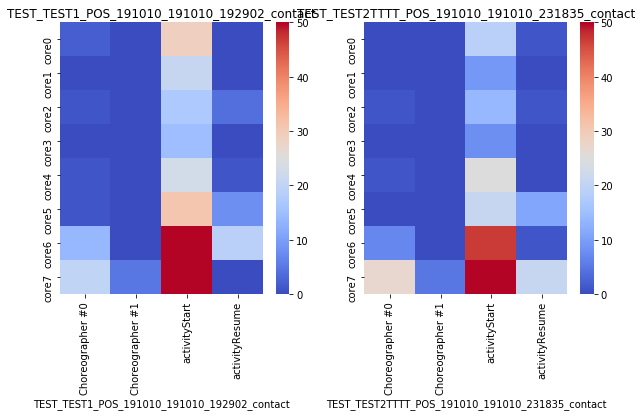

In [23]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [24]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,2,0,NaN,29,NaN,0,NaN
core1,NaN,0,0,NaN,21,NaN,0,NaN
core2,NaN,1,0,NaN,17,NaN,4,NaN
core3,NaN,0,0,NaN,15,NaN,0,NaN
core4,NaN,1,0,NaN,23,NaN,1,NaN
core5,NaN,1,0,NaN,31,NaN,8,NaN
core6,NaN,14,0,NaN,62,NaN,19,NaN
core7,NaN,20,5,NaN,81,NaN,0,NaN


In [25]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,19,NaN,1,NaN
core1,NaN,0,0,NaN,9,NaN,0,NaN
core2,NaN,1,0,NaN,14,NaN,1,NaN
core3,NaN,0,0,NaN,8,NaN,0,NaN
core4,NaN,1,0,NaN,25,NaN,0,NaN
core5,NaN,0,0,NaN,21,NaN,11,NaN
core6,NaN,7,0,NaN,47,NaN,1,NaN
core7,NaN,27,5,NaN,94,NaN,21,NaN


In [26]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [27]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected        time
activityStart    0    I  I  I  I  I  V  R  R         5  334.315547
                 1    I  I  I  I  I  I  V  R         6  334.316281
                 2    I  I  I  I  I  R  V  R         6  334.316782
                 3    I  I  I  R  I  V  R  I         5  334.321229
                 4    I  I  I  I  I  R  I  V         7  334.324098
                 5    I  I  I  R  I  I  R  V         7  334.324149
                 6    I  I  I  I  I  I  R  V         7  334.324887
                 7    I  I  I  I  I  I  R  V         7  334.324935
                 8    I  I  I  I  I  I  R  V         7  334.324960
                 9    I  I  I  I  I  I  I  V         7  334.324972
                 10   I  I  I  I  I  I  R  V         7  334.324988
                 11   I  I  I  I  I  I  R  V         7  334.325004
                 12   I  I  I  I  I  R  I  V         7  334.326588
                 13   I  R  I  R  R  V  R  R         5  334.357754
                 14   R  R  I  I  V  R  R  R         4  334.362114
                 15   I  I  I  I  I  I  R  V         7  334.362875
                 16   R  I  I  R  I  R  I  V         7  334.365789
                 17   R  I  I  V  R  R  R  R         3  334.367273
                 18   I  I  I  R  R  R  V  R         6  334.368091
                 19   I  I  I  I  I  I  V  R         6  334.368163
                 20   I  R  I  R  V  I  R  R         4  334.373708
                 21   I  I  I  R  I  V  R  R         5  334.375049
                 22   I  I  I  R  R  V  I  R         5  334.375734
                 23   I  I  I  V  R  R  I  I         3  334.377541
                 24   I  I  R  I  I  V  R  R         5  334.378403
                 25   I  I  V  R  R  I  R  I         2  334.378540
                 26   I  I  R  I  I  R  R  V         7  334.378721
                 27   I  I  R  R  V  R  R  I         4  334.380129
                 28   R  I  V  R  I  R  I  I         2  334.380264
                 29   I  I  I  I  I  V  R  R         5  334.381708
                 30   V  I  R  R  I  R  I  I         0  334.382390
                 31   R  I  R  I  V  R  R  I         4  334.382863
                 32   I  I  I  I  I  R  V  I         6  334.383333
                 33   I  R  R  R  I  V  R  I         5  334.384995
                 34   I  R  V  R  I  I  I  I         2  334.385036
                 35   I  I  R  R  R  R  I  V         7  334.385378
                 36   I  I  I  R  I  R  R  V         7  334.387232
                 37   I  R  R  R  R  I  I  V         7  334.387766
                 38   I  I  I  I  I  V  I  I         5  334.388176
                 39   I  I  I  V  R  I  I  I         3  334.388544
                 40   R  I  I  I  I  I  R  V         7  334.390210
                 41   I  I  I  I  I  I  V  R         6  334.391348
                 42   I  I  I  R  I  I  I  V         7  334.391770
                 43   I  I  R  R  I  I  I  V         7  334.391957
                 44   I  I  R  R  I  I  V  R         6  334.392249
                 45   I  I  R  I  I  V  R  I         5  334.393041
                 46   I  I  I  I  I  V  R  R         5  334.395009
                 47   V  I  I  I  I  I  R  R         0  334.395086
                 48   I  I  I  I  I  V  R  R         5  334.395445
                 49   V  I  I  I  I  R  R  R         0  334.395537
                 50   V  I  R  R  I  I  R  R         0  334.396290
                 51   I  I  R  R  I  V  R  R         5  334.396618
                 52   I  V  R  I  R  I  R  R         1  334.396971
                 53   I  I  R  I  V  R  R  R         4  334.397645
                 54   R  I  I  I  V  R  I  R         4  334.398379
                 55   I  I  R  R  I  I  V  R         6  334.399510
                 56   I  I  I  R  I  R  I  V         7  334.400179
                 57   I  I  R  R  R  R  V  I         6  334.400984
                 58   I  R  I  R  R  V  I  I         5  334.401826
  

In [28]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected        time
activityStart    0    I  I  R  I  I  R  V  R         6  326.101650
                 1    I  I  I  R  R  I  R  V         7  326.102389
                 2    I  R  I  I  I  R  R  V         7  326.107365
                 3    I  I  I  I  I  R  R  V         7  326.109628
                 4    I  I  I  I  R  R  R  V         7  326.109651
                 5    I  I  I  R  R  R  R  V         7  326.109670
                 6    I  I  I  I  R  R  R  V         7  326.109690
                 7    I  I  I  I  R  R  R  V         7  326.109704
                 8    I  I  I  R  R  R  R  V         7  326.109721
                 9    I  I  I  R  V  R  R  I         4  326.110187
                 10   I  I  I  I  I  R  R  V         7  326.110327
                 11   I  I  I  I  I  R  R  V         7  326.110366
                 12   I  R  I  V  R  R  R  R         3  326.142804
                 13   R  R  I  V  R  I  I  I         3  326.143306
                 14   I  R  R  I  I  I  I  V         7  326.144121
                 15   R  I  I  R  V  I  R  I         4  326.145858
                 16   I  R  R  R  V  R  R  R         4  326.151692
                 17   I  I  R  I  I  R  V  R         6  326.156521
                 18   I  I  I  R  V  R  I  I         4  326.157549
                 19   I  I  I  I  V  R  I  R         4  326.158737
                 20   R  I  R  I  I  R  I  V         7  326.159870
                 21   R  I  R  R  I  V  R  I         5  326.161572
                 22   I  I  I  I  R  I  I  V         7  326.162670
                 23   I  I  R  I  R  R  I  V         7  326.163616
                 24   I  I  R  I  R  R  R  V         7  326.163672
                 25   I  I  I  R  R  I  V  R         6  326.163999
                 26   I  I  I  I  R  I  V  R         6  326.165015
                 27   I  I  I  R  V  R  R  I         4  326.165482
                 28   I  I  R  I  I  R  I  V         7  326.166013
                 29   I  I  I  I  I  R  I  V         7  326.166802
                 30   I  I  I  I  I  R  V  R         6  326.167221
                 31   R  I  I  R  V  R  I  R         4  326.168094
                 32   I  I  I  R  I  I  V  R         6  326.168154
                 33   R  I  R  R  V  R  I  I         4  326.169439
                 34   R  I  V  I  R  R  I  I         2  326.169878
                 35   I  I  V  R  I  R  I  I         2  326.171148
                 36   I  I  I  R  I  V  R  R         5  326.171628
                 37   I  I  I  I  V  R  R  R         4  326.174725
                 38   R  I  V  R  R  R  I  R         2  326.176100
                 39   R  R  I  I  I  V  R  R         5  326.176701
                 40   I  R  V  R  R  I  I  R         2  326.178383
                 41   I  I  V  I  R  I  I  R         2  326.180153
                 42   I  I  I  R  R  I  I  V         7  326.181484
                 43   I  R  I  I  R  I  V  R         6  326.181992
                 44   R  R  I  R  I  I  R  V         7  326.182448
                 45   I  I  I  I  R  R  R  V         7  326.186699
                 46   I  I  I  I  V  R  R  I         4  326.187427
                 47   R  I  I  R  I  V  R  R         5  326.188358
                 48   I  R  I  I  I  I  V  R         6  326.189385
                 49   I  I  R  I  I  I  I  V         7  326.190044
                 50   I  I  I  I  I  I  R  V         7  326.190200
                 51   I  I  R  I  I  I  I  V         7  326.190934
                 52   R  I  I  I  I  R  I  V         7  326.191431
                 53   I  I  R  R  I  V  R  R         5  326.192400
                 54   I  R  R  I  I  R  V  R         6  326.193527
                 55   I  I  R  R  I  I  R  V         7  326.195304
                 56   I  I  I  R  I  R  V  R         6  326.196666
                 57   I  R  I  I  I  I  I  V         7  326.201307
                 58   I  I  I  I  I  I  V  I         6  326.202174
  

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [29]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

In [30]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

TypeError: Index(...) must be called with a collection of some kind, 'cpu_frequency_limits:' was passed

In [ ]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [ ]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

In [ ]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

In [ ]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [ ]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

In [ ]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [ ]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

In [ ]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

Sum of the lock contention's duration. The durations could be duplicated.

In [ ]:
display(group1.title)
display(df1['duration'].sum())

In [ ]:
display(group2.title)
display(df2['duration'].sum())

Liminated the lock contentions by owners.

In [ ]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

In [ ]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

In [ ]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')